In [ ]:
import os
import sys
from typing import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(os.sep.join(os.getcwd().split(os.sep)[:-1]))
from src.quanta_utils import *
from src.SegregationIdx import SegregationIdx

In [16]:
def plot_histogram_with_lines(values, observed, shuffled_5_per, bins=30, title="Value Distribution", xlabel="Value", ylabel="Frequency", text=None, text_position=(0.5, 0.9)):
    """
    Plot a histogram of the given values with two vertical lines for precomputed values and optional text.

    Parameters:
    - values: list or array of 1000 numeric values
    - observed: float, position of the first vertical reference line
    - shuffled_5_per: float, position of the second vertical reference line
    - bins: int, number of histogram bins
    - title: str, title of the plot
    - xlabel: str, label for the x-axis
    - ylabel: str, label for the y-axis
    - text: str, optional text to display on the plot
    - text_position: tuple, position of the text in axes coordinates (x, y)
    """
    # Set colorblind-friendly palette
    sns.set_palette("colorblind")
    sns.set_context("talk")  # For better font sizes
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(values, bins=bins, kde=False, color=sns.color_palette("colorblind")[0])

    # Plot vertical lines
    plt.axvline(observed, color=sns.color_palette("colorblind")[2], linestyle="--", linewidth=2, label=f"observed = {observed:.2f}")
    plt.axvline(shuffled_5_per, color=sns.color_palette("colorblind")[1], linestyle="--", linewidth=2, label=f"shuffled 5% = {shuffled_5_per:.2f}")

    # Add text to the plot if provided
    if text:
        p_v = sum(observed > values) / len(values)
        plt.text(text_position[0], text_position[1], f"SPI= {text:.3f}", fontsize=14, transform=plt.gca().transAxes, ha='center')
        plt.text(text_position[0], text_position[1]-0.05, f"p={p_v:.3f}" if p_v>0.001 else "p<0.001", fontsize=12, transform=plt.gca().transAxes, ha='center')
    # Axis labels and title
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)

    # Tick label formatting
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Legend
    plt.legend(fontsize=12, loc="upper right")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


## SPI permuataion and statistical significance 

Processing file 1: field13_crop-001_ROI#1_annotation_apop.csv
0.05747126436781611


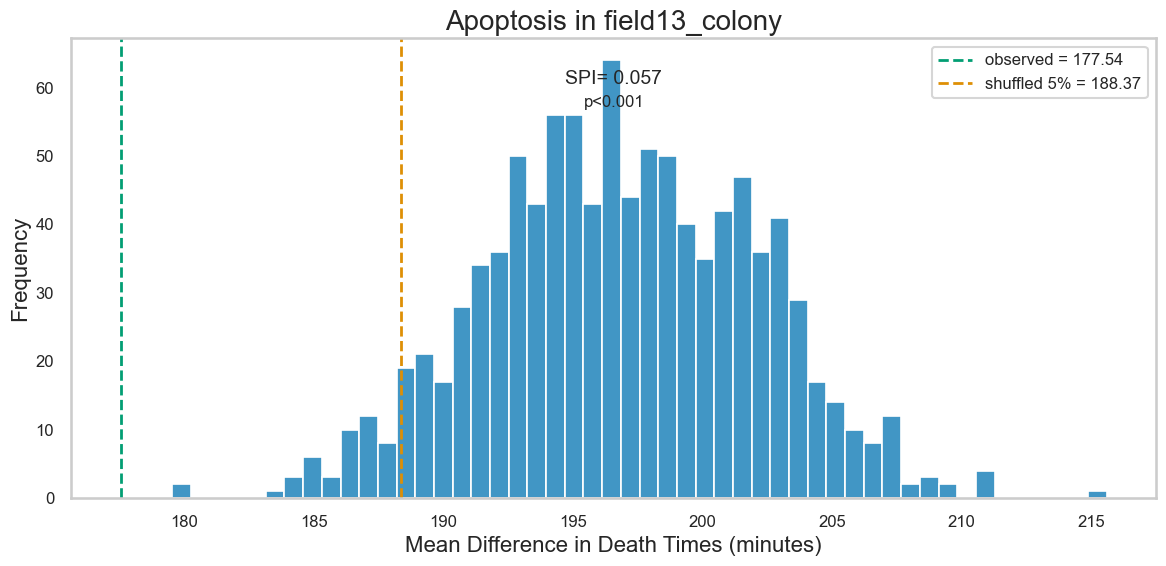

Processing file 2: field13_crop-001_ROI#1_annotation_nec.csv
0.264300507034207


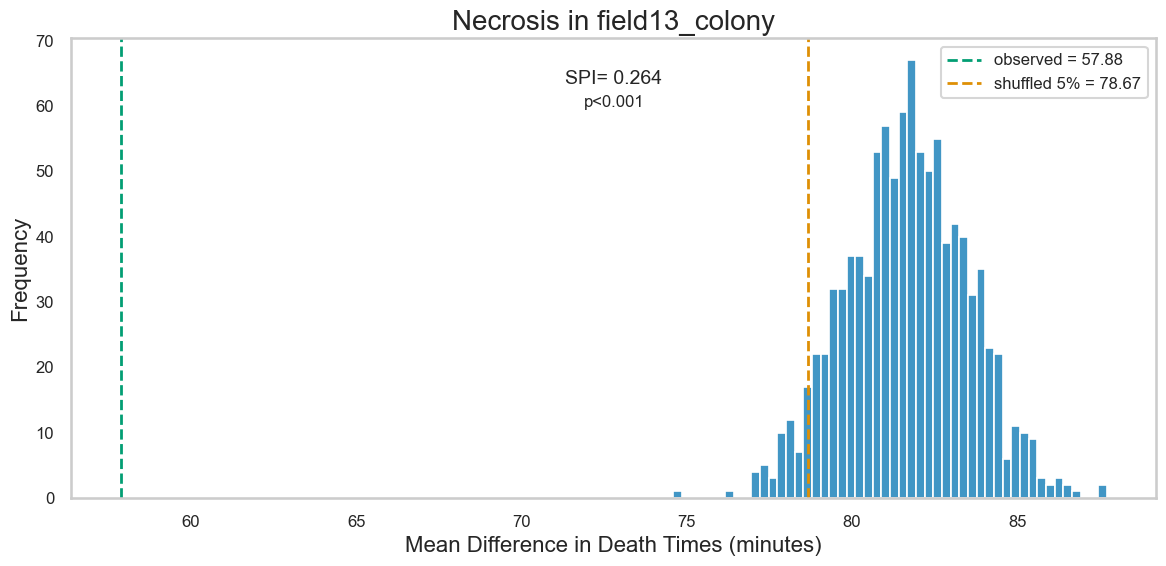

Processing file 3: Field14-002_ROI#1_annotation_apop.csv
0.1620791935450417


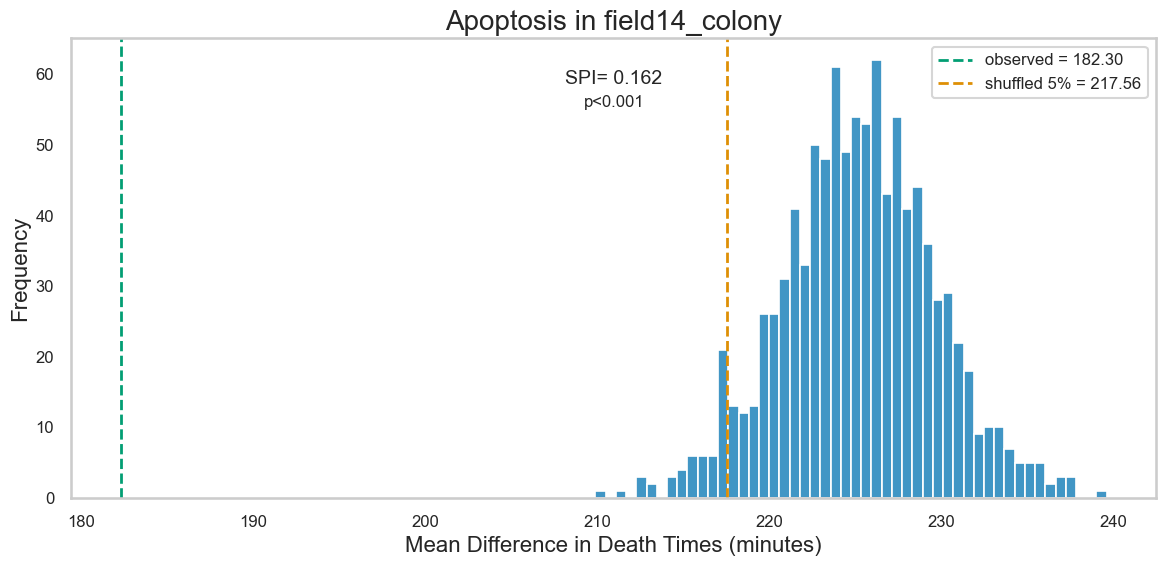

Processing file 4: Field14-002_ROI#1_annotation_nec.csv
0.2084131545338442


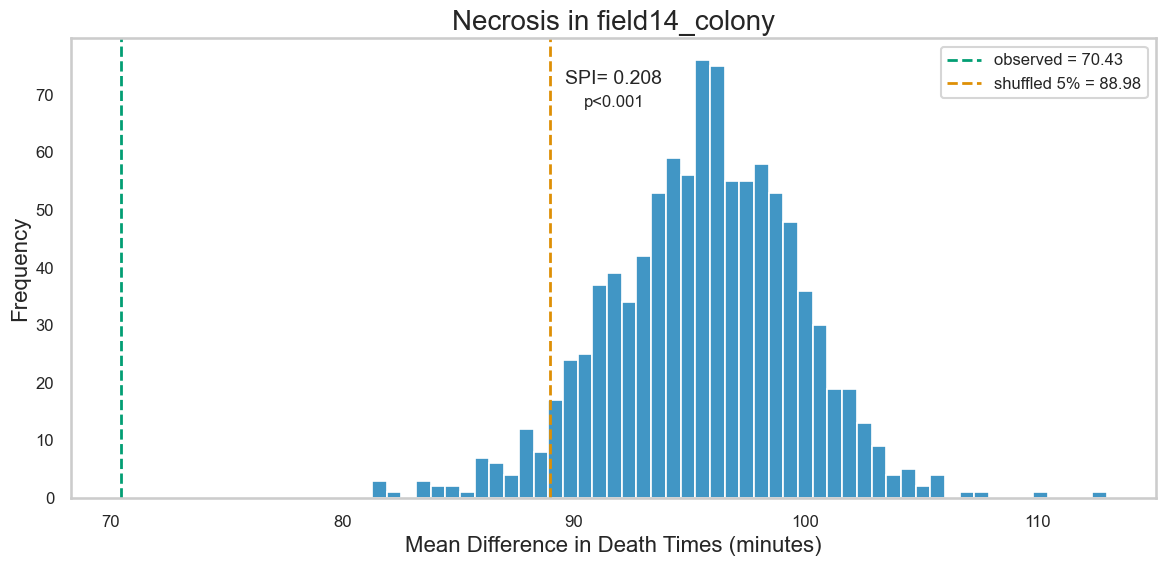

Processing file 5: 7-20-23_10arednuclei_ROI#10_annotation_apop.csv
0.043115438108483874


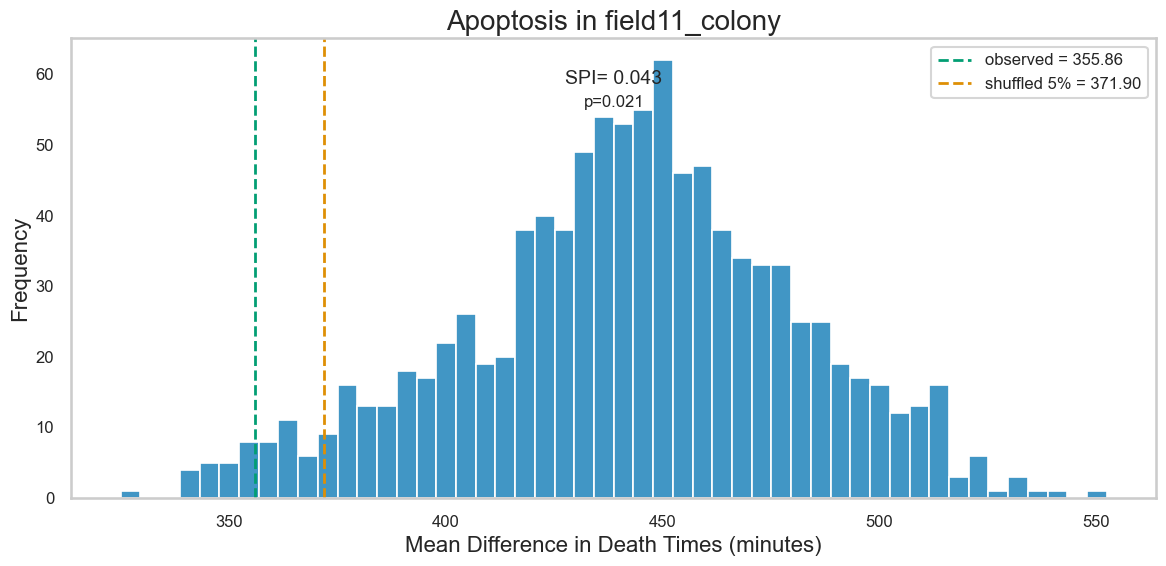

Processing file 6: 7-20-23_10arednuclei_ROI#10_annotation_nec.csv
0.3248746391125969


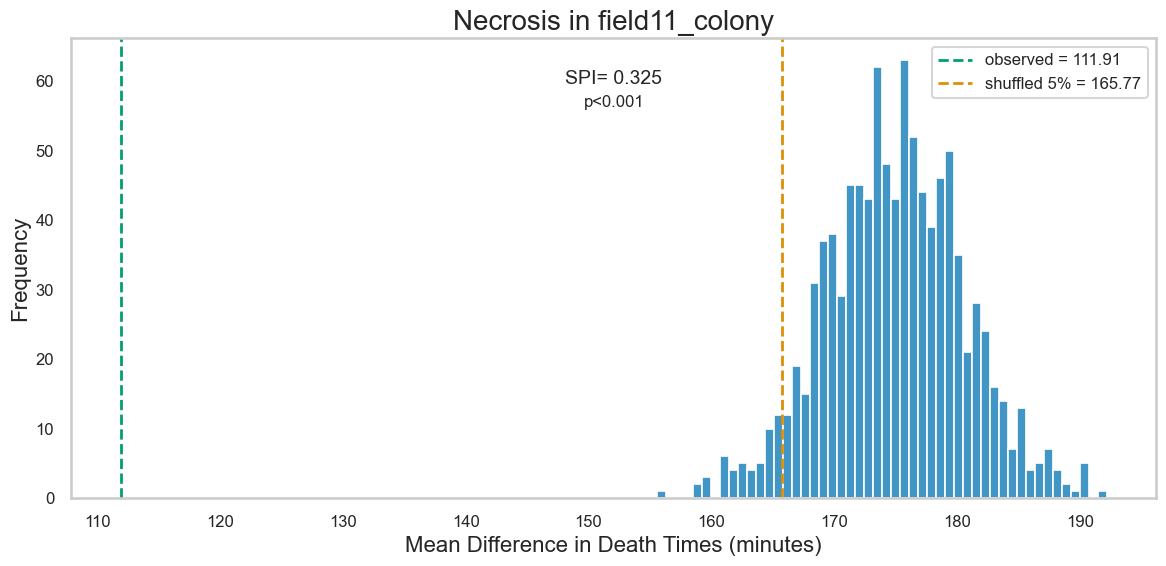

Processing file 7: 7-20-23_10arednuclei_ROI#13_or14_both_colonies_annotation_apop.csv
0.24785258057411344


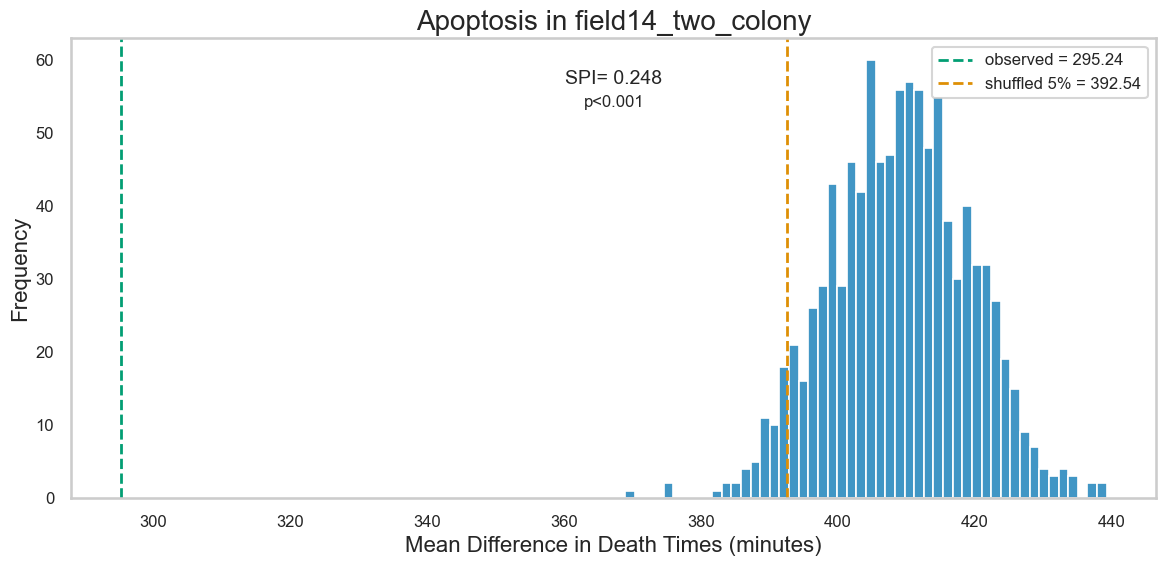

Processing file 8: 7-20-23_10arednuclei_ROI#13_or14_both_colonies_annotation_nec.csv
0.5464231354642314


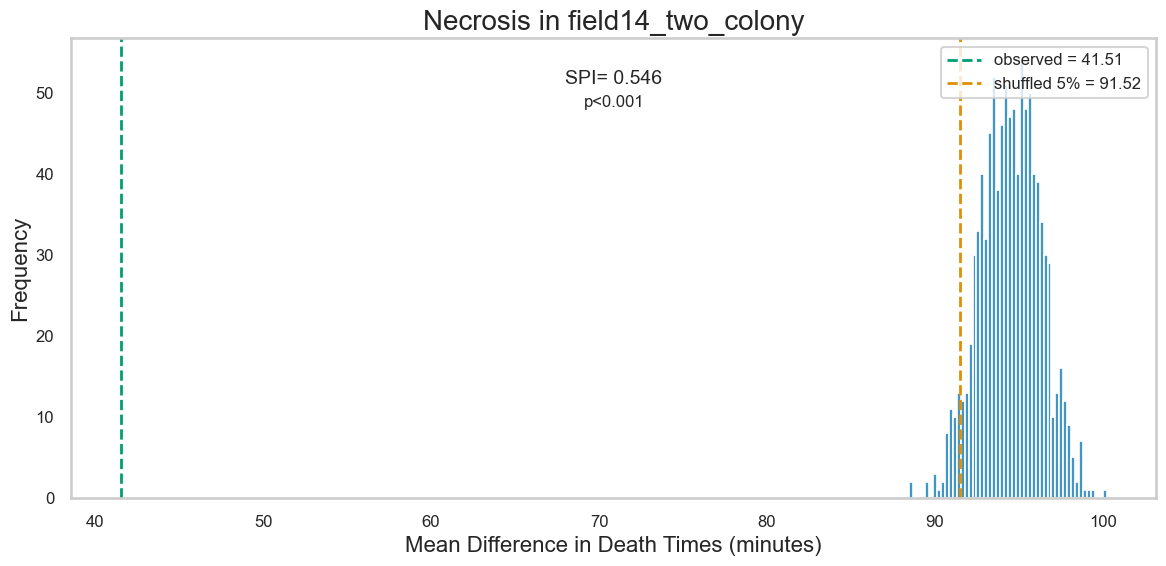

In [17]:
single_exp_full_paths = os.sep.join(os.getcwd().split(os.sep)[:-1]) + "/data/mixed_death_annotations/"#Field14-002_ROI#1_annotation_nec.csv'
exps_dir_name = os.sep.join(os.getcwd().split(os.sep)[:-1]) + "/data/mixed_death_annotations/"
meta_data_file_full_path= os.sep.join(os.getcwd().split(os.sep)[:-1]) + "/data/metadata.csv"
meta_data_df = pd.read_csv(meta_data_file_full_path)
meta_data_df = meta_data_df[meta_data_df["File Name"].str.contains("nec|apop")]
for idx, file in enumerate(meta_data_df['File Name'].values):
    print(f"Processing file {idx+1}: {file}")
    cells_loci, cells_times_of_death = read_experiment_cell_xy_and_death_times(exp_full_path=os.path.join(single_exp_full_paths, file))
    csv = pd.read_csv(os.path.join(single_exp_full_paths, file))
    death_mode = csv["Mode"].values
    ob = uSpiCalc(XY=cells_loci,
                        die_times=cells_times_of_death,
                        death_mode = death_mode,
                        treatment='ML162',
                        temporal_resolution=10,
                        n_scramble=1000,
                        draw=False,
                        dist_threshold=100, 
                        filter_neighbors_by_distance=True,
                        filter_neighbors_by_level= 1,
                        time_unit='minutes',)
    print(ob.get_uspis())
    mean_of_shuffles = ob.all_mean_shuffles_sorted
    # flattened_array = np.concatenate(mean_of_shuffles).ravel().tolist()
    flattened_array = np.array(mean_of_shuffles)
    # print(flattened_array)
    mean_5_pre =  ob.scramble_signficance_95
    mean_observed = ob.original_difference_death_times
    new = "Necrosis in " + meta_data_df[meta_data_df["File Name"].str.contains(file)]["Origin"].values[0] if 'nec' in file else "Apoptosis in " + meta_data_df[meta_data_df["File Name"].str.contains(file)]["Origin"].values[0]
    plot_histogram_with_lines(flattened_array, observed=mean_observed, shuffled_5_per= mean_5_pre, bins=50, title=new, xlabel="Mean Difference in Death Times (minutes)", ylabel="Frequency", text = ob.get_uspis())

## SSI permuations and statistical significance

In [ ]:

per_5 = {}
# single_exp_full_paths = '/sise/assafzar-group/assafzar/Esraa/SalJyoPaperFiles/csv_files_minutes_microns_sytox/'
res_si = {}
res_ob = {}
p_values = {}
expected_lik = {}
mean_shuffled = {}
shuffle_mean_full_arrays = {}
for idx, file in enumerate(os.listdir(single_exp_full_paths)):
    print(file)
    if '_mixed' not in file:
        continue
    cells_loci, cells_times_of_death = read_experiment_cell_xy_and_death_times(exp_full_path=os.path.join(single_exp_full_paths, file))
    exp_full_path = os.path.join(single_exp_full_paths, file)
    csv_file = pd.read_csv(exp_full_path)
    dist_threshold = 100
    death_modes = csv_file[["Mode"]].values
    segregation_index = SegregationIdx(cells_loci, death_modes, 1000, dist_threshold, filter_neighbors_by_distance=True, neighbors_level=1, stats_to_calculate="mean")
    seg_res_dict = segregation_index.get_segregation_index(num_permutations = 1000)
    distr_dict = segregation_index.permuted_si
    new_file = file
    print(seg_res_dict)
    per_5[file] = {key: np.percentile(sorted(value),95) for key, value in distr_dict.items() if key in ('apoptosis', 'necrosis')}
    mean_shuffled[file] = {key: np.mean(value) for key, value in distr_dict.items() if key in ('apoptosis', 'necrosis')}
    shuffle_mean_full_arrays [file] = {key: value for key, value in distr_dict.items() if key in ('apoptosis', 'necrosis')}
    res_si[file] = {key: ((value[0] / value[2]), value[1]) for key, value in seg_res_dict.items() if key in ('apoptosis', 'necrosis')}
    res_ob[file] =  {key: (value[0]) for key, value in seg_res_dict.items() if key in ('apoptosis', 'necrosis')}
    p_values[file] = {key: (value[1]) for key, value in seg_res_dict.items() if key in ('apoptosis', 'necrosis')}
    expected_lik[file] = {key: (value[2]) for key, value in seg_res_dict.items() if key in ('apoptosis', 'necrosis')}


plot_res_dict = {new_res.get(key, key): value for key, value in res_si.items()}  # Provide default key if not found

data = []

# Iterate over the file names in new_res
for file_name, origin in new_res.items():
    for mode in ['apoptosis', 'necrosis']:
        data.append({
            'File Name': file_name,
            'Origin': origin,
            'Mode': mode,
            'Observed': res_ob.get(file_name, {}).get(mode, None),
            'Expected': expected_lik.get(file_name, {}).get(mode, None),
            'Percentile_95': per_5.get(file_name, {}).get(mode, None),
            'Segregation Index': plot_res_dict.get(origin, {}).get(mode, (None,))[0],
            'Mean Shuffled': mean_shuffled.get(file_name, {}).get(mode, None),
            'Shuffle Mean Full Arrays': shuffle_mean_full_arrays.get(file_name, {}).get(mode, None),
            'p-value': p_values.get(file_name, {}).get(mode, None)
        })

# Create a DataFrame
df = pd.DataFrame(data)



7-20-23_10arednuclei_ROI#10_annotation_mixed.csv
{'apoptosis': (np.float64(0.3807497467071936), np.float32(0.0), np.float64(0.24867724867724866)), 'necrosis': (np.float64(0.7983428347864967), np.float32(0.0), np.float64(0.7513227513227513))}
field13_crop-001_ROI#1_annotation_mixed.csv
{'necrosis': (np.float64(0.8038025889967637), np.float32(0.0), np.float64(0.5659340659340659)), 'apoptosis': (np.float64(0.7556777844752527), np.float32(0.0), np.float64(0.4340659340659341))}
7-20-23_10arednuclei_ROI#10_annotation_nec.csv
Field14-002_ROI#1_annotation_nec.csv
7-20-23_10arednuclei_ROI#13_or14_both_colonies_annotation_mixed.csv
{'apoptosis': (np.float64(0.9302195340501791), np.float32(0.0), np.float64(0.41680672268907565)), 'necrosis': (np.float64(0.9508885686839577), np.float32(0.0), np.float64(0.5831932773109244))}
7-20-23_10arednuclei_ROI#13_or14_both_colonies_annotation_apop.csv
Field14-002_ROI#1_annotation_apop.csv
7-20-23_10arednuclei_ROI#13_or14_both_colonies_annotation_nec.csv
Field1

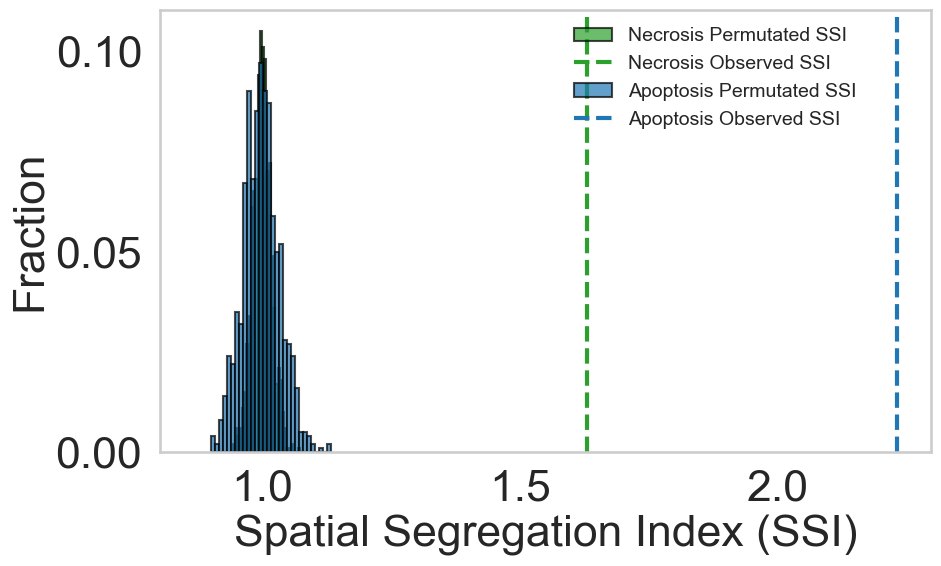

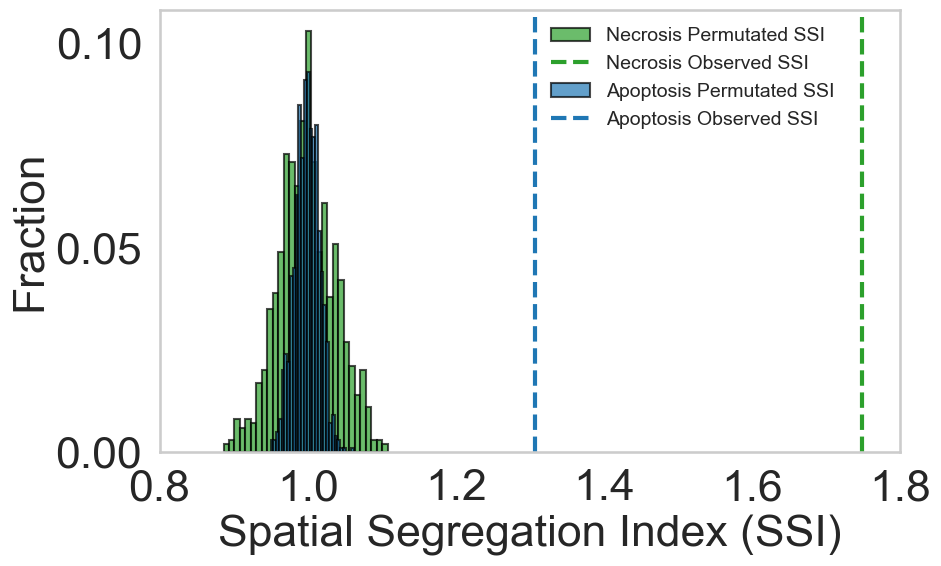

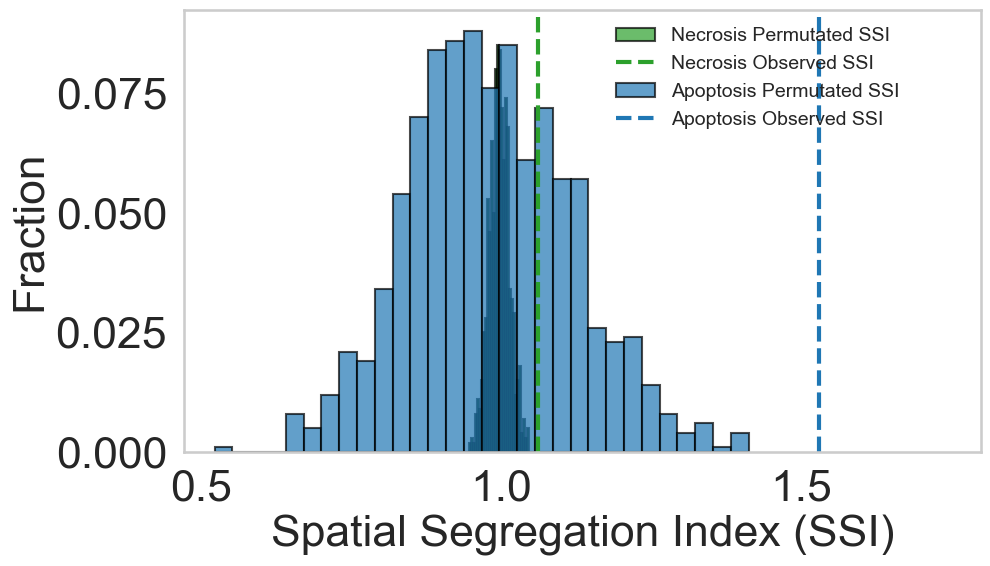

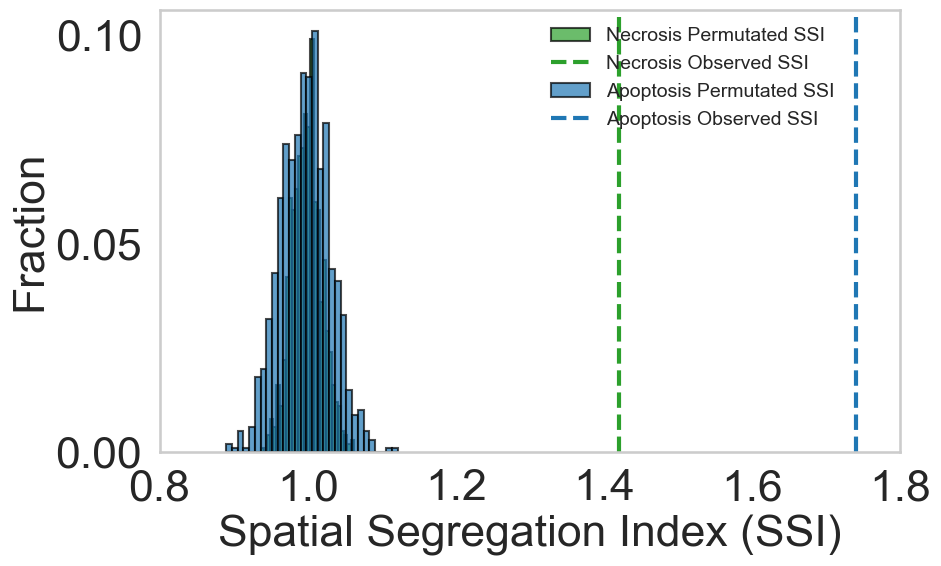

In [11]:
# Filter the data for a single origin
custom_palette =  {"apoptosis": "#1f77b4", "necrosis": "#2ca02c", "other": "lightgray"} #{"apoptosis": "#bf7745", "necrosis": "#f5e18a"} #

for single_origin in df['Origin'].unique():
    origin_data = df[df['Origin'] == single_origin]

    # Create a single subplot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Iterate over both necrosis and apoptosis
    for mode in ['necrosis', 'apoptosis']:
        mode_data = origin_data[origin_data['Mode'] == mode]
        full_array = mode_data.iloc[0]['Shuffle Mean Full Arrays']
        observed_value = mode_data.iloc[0]['Observed']

        # Plot the histogram of the full array as a fraction of 1000
        ax.hist(
            full_array / mode_data.iloc[0]['Expected'],
            bins=30,
            alpha=0.7,
            color=custom_palette[f"{mode}"],
            edgecolor='black',
            label=f"{mode.capitalize()} Permutated SSI",
            weights=np.ones_like(full_array) / 1000  # Normalize to fraction of 1000
        )

        # Add a red line for the observed value
        ax.axvline(
            observed_value / mode_data.iloc[0]['Expected'],
            color=custom_palette[f"{mode}"],
            linestyle='--',
            linewidth=3,
            label=f"{mode.capitalize()} Observed SSI"
        )
        ax.set_facecolor('none')

    # Add labels, title, and legend
    ax.legend(frameon=False, fontsize=14, loc='upper center', bbox_to_anchor=(0.72, 1.0))

    plt.gca().tick_params(axis='x', which='major', length=9, width=2, labelsize=32)
    plt.gca().tick_params(axis='x', which='minor', length=5, width=1)
    plt.gca().tick_params(axis='y', which='major', length=9, width=2, labelsize=32)
    plt.gca().tick_params(axis='y', which='minor', length=5, width=1)
    plt.gca().set_yticks(np.arange(0, 0.10, 0.01), minor=True)  # Adjusted for fractions
    plt.gca().set_xticks(np.arange(0.8, 1.85, 0.1), minor=True)

    plt.xlabel("Spatial Segregation Index (SSI)", fontsize=32)
    plt.ylabel("Fraction", fontsize=32)  # Updated label
    plt.grid(False)
    plt.tight_layout()
    plt.gca().set_facecolor('none')
    plt.show()